In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate
import Utils
from Utils import Constants
import cv2
from facenet_pytorch import InceptionResnetV1

In [6]:
train_labels = pd.read_csv('train_data_clean.csv')
test_labels = pd.read_csv('test_data_clean.csv')
validation_labels = pd.read_csv('validation_data_clean.csv')
train_labels

,name,skin_tone,gender,age,is_face
0,TRAIN0001.png,0,0,1,False
1,TRAIN0002.png,5,1,0,True
2,TRAIN0005.png,1,1,0,False
3,TRAIN0007.png,1,0,1,True
4,TRAIN0009.png,7,0,1,False
...,...,...,...,...,...
6837,TRAIN9992.png,4,0,2,True
6838,TRAIN9993.png,1,1,1,True
6839,TRAIN9995.png,8,0,1,True
6840,TRAIN9998.png,4,1,1,False


In [13]:
def read_image(file,size=None):
    img = Image.open(Constants.data_root+file).convert('RGB')
    if size is not None:
        img = cv2.resize(img,(size,size))
    img = np.array(img).astype(np.float32)/255
    return img

(256, 256, 3)


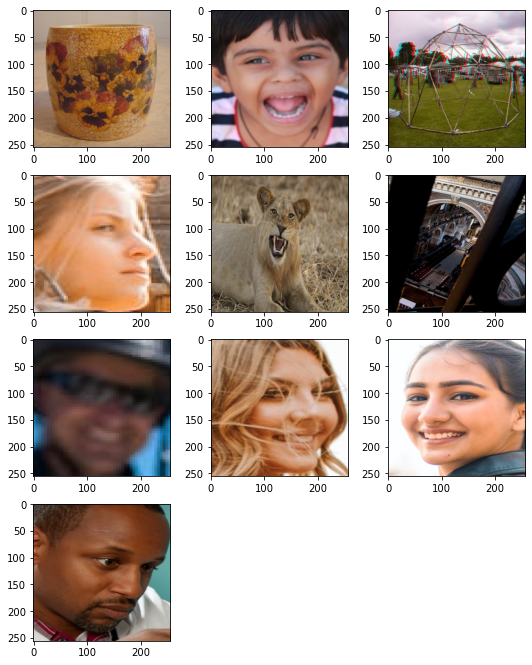

In [30]:
class Augmentor():
    
    def __init__(self,image_size = None,noise_sigma=.03):
        if image_size is None:
            image_size = Constants.resnet_size
        self.image_size = image_size
        self.noise_sigma = noise_sigma
        
    def random_range(self,min_ratio = 0.01, max_ratio = .9):
        return max(min(max_ratio,1.5*np.random.random()), min_ratio)
    
    def random_crop(self,img):
        ratio = self.random_range(min_ratio=0.5)
        crop_size = [int(img.shape[0]*ratio), int(img.shape[1]*ratio)]
        assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
        img = img.copy()
        w, h = img.shape[:2]
        x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
        img = img[y:y+crop_size[0], x:x+crop_size[1]]
        return img
    
    def random_rotation(self,img, bg_patch=(5,5)):
        assert len(img.shape) <= 3, "Incorrect image shape"
        angle = (self.random_range(.01,.99)*360 - 180)
        rgb = len(img.shape) == 3
        if rgb:
            bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
        else:
            bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
        img = rotate(img, angle,reshape=False)
        mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
        img[mask] = bg_color
        return img
    
    def gaussian_noise(self,img, mean=0):
        img = img.copy()
        noise = (np.random.normal(mean, self.noise_sigma, img.shape)).astype(np.float16)
        mask_overflow_upper = img+noise >= 1
        mask_overflow_lower = img+noise < 0
        noise[mask_overflow_upper] = 1
        noise[mask_overflow_lower] = 0

        img += noise
        return img
    
    
    def color_shift(self,img):
        img = img.copy().astype(np.float16)
        for channel in [0,1,2]:
            img[channel] *= .5 + self.random_range(.1,.9)
        return img
    
    def augment_image(self,img,crop=True,rotate=True,noise=True,color_shift=False):
        shape = img.shape
        if img.ndim < 3 or shape[0] == 0 or shape[1] == 0 or shape[2] == 0:
            print('bad shape',shape)
        if crop:
            img = self.random_crop(img)
        if rotate:
            img = self.random_rotation(img)
        if noise:
            img = self.gaussian_noise(img)
        if color_shift:
            img = self.color_shift(img)
        img = self.format_image(img)
        return img
    
    def augment_images(self,images,**kwargs):
        images = np.stack([self.augment_image(i,**kwargs) for i in images])
        return images
    
    def format_image(self,images,normalize=False,whiten=False,resnet_normalize=False):
        images = images.astype(np.float32)
        if images.max() > 1:
            images = images/images.max()
        
        if whiten:
            images = Utils.prewhiten(images)
        if normalize:
            images = Utils.l2_normalize(images)
        if resnet_normalize:
            images = resnet_preprocess(images)
        images = cv2.resize(images,[self.image_size, self.image_size])
        return images
   
def plot_selection(images,rows=20,columns=3):
    fig = plt.figure(figsize=(3*columns, 3*rows))
    # setting values to rows and column variables
    for i in range(rows*columns):
        if i >= len(images):
            return
        image = images[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(image)
        
    return

augmentor = Augmentor()
ti = [read_image(n) for n in train_labels.iloc[0:10].name]
print(ti[0].shape)
plot_selection(ti)

(160, 160, 3) [(0.011099204, 0.87755525), (0.010582913, 1.0), (0.00053806684, 0.998853), (0.009101789, 0.99183923), (0.013556738, 0.86393386), (0.0, 0.9280586), (0.003515429, 0.9703175), (0.0017184428, 0.997628), (0.05896639, 1.0), (5.744486e-06, 0.9929555)]


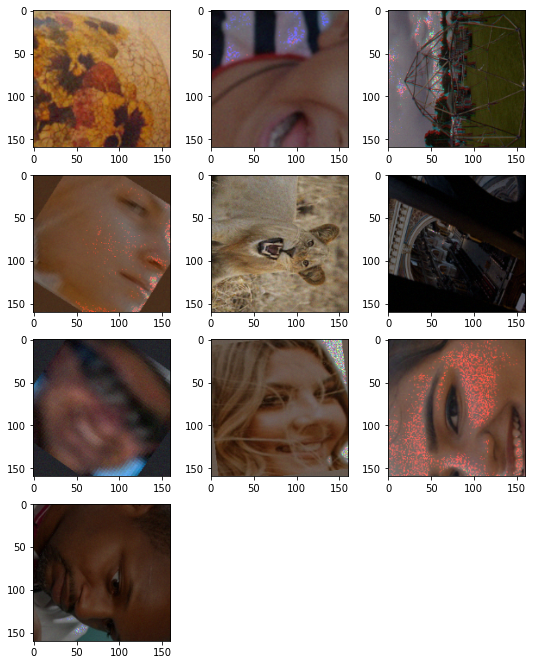

In [31]:
test_images = np.stack(ti)
test_images = augmentor.augment_images(test_images)
print(test_images[0].shape,[(t.min(),t.max()) for t in test_images])
plot_selection(test_images)
del test_images
del ti
del augmentor

In [61]:
def add_group(df,labels=None,filter_face = True):
    if labels is None:
        labels = Constants.labels
    if filter_face:
        df = df[df.is_face]
    to_string = lambda row: '-'.join([str(x) for x in row])
    df = df.copy()
    df['group'] = df.apply(lambda row: to_string(row[labels]),axis=1)
    return df
    
def calc_label_upsample(df,**kwargs):
    if 'group' not in df.columns:
        df = add_group(df,**kwargs)
    counts = {}
    max_group = 0
    min_group = df.shape[0]
    for group,subdf in df.groupby('group'):
        size = subdf.shape[0]
        counts[group] = size
        max_group = max(max_group,size)
        min_group = min(min_group,size)
    #get the number of times you'd need to upsample 
    ratios = {k: 1/(v/max_group) for k,v in counts.items()} 
    return ratios

def upsample_data(df,fit_df=None,**kwargs):
    if fit_df is None:
        fit_df = df.copy()
        
    fit_df = add_group(fit_df,**kwargs)
    df = add_group(df,**kwargs)

    ratios = calc_label_upsample(fit_df)
    df['group_ratio'] = df.group.apply(lambda x: ratios.get(x,1))
    new_df = []
    for i,row in df.iterrows():
        repeats = np.ceil(row.group_ratio).astype(int)
        for ii in range(repeats):
            new_df.append(row)
    return pd.DataFrame(new_df).reset_index().drop(['index','group','group_ratio'],axis=1)

upsample_data(train_labels)

,name,skin_tone,gender,age,is_face
0,TRAIN0002.png,5,1,0,True
1,TRAIN0002.png,5,1,0,True
2,TRAIN0002.png,5,1,0,True
3,TRAIN0002.png,5,1,0,True
4,TRAIN0002.png,5,1,0,True
...,...,...,...,...,...
35349,TRAIN9999.png,3,1,1,True
35350,TRAIN9999.png,3,1,1,True
35351,TRAIN9999.png,3,1,1,True
35352,TRAIN9999.png,3,1,1,True


In [67]:
def imgs_to_np(array):
    array = array.cpu().numpy()
    if array.ndim > 3:
        return np.moveaxis(array,1,-1)
    return np.moveaxis(array,0,-1)

def imgs_to_torch(array,convert=False):
    if array.ndim > 3:
        array = np.moveaxis(array,-1,1)
    else:
        array = np.moveaxis(array,-1,0)
    if convert:
        array = torch.from_numpy(array)
    return array


class FaceGeneratorIterator(torch.utils.data.Dataset):
    
    def __init__(self,df,root,
                 filter_nonfaces=True,
                 batch_size=1,
                 image_shape=None,
                 labels=None,
                 regularize_labels=False,
                 upsample=True,
                 fit_df=None,
                 shuffle_on_init=True,
                 validation = False,
                 preload=False,
                 **kwargs):
        super(FaceGeneratorIterator,self).__init__()
        df = df.copy()
        if fit_df is None:
            fit_df = df.copy()
        if filter_nonfaces:
            df = df[df.is_face]
            fit_df = fit_df[fit_df.is_face]
        if upsample:
            df = upsample_data(df,fit_df=fit_df)
        if shuffle_on_init:
            df = df.sample(frac=1)
        self.df = df
        
        self.image_shape = image_shape if image_shape is not None else Constants.resnet_size
        self.batch_size = 1
        self.root=root
        
        self.labels = labels if (labels is not None) else Constants.labels
        
        self.n_classes = {label: len(self.df[label].unique()) for label in self.labels}
        self.augmentor = Augmentor(**kwargs)
        if regularize_labels:
            self.df[self.labels] = self.df[self.labels].values/self.df[self.labels].max().values
        
        
        self.shuffle_on_epoch = not validation
        self.augment_images = not validation
        
        if preload:
            self.df['image'] = self.df.name.apply(self.process_image_file)
        self.preloaded = preload
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def __len__(self):
        return self.df.shape[0]
            
        
    def __getitem__(self,idx):
        subdf = self.df.iloc[idx]
        return self.process_files(subdf)
        
    def batch_subset(self,idx):
        start = idx*self.batch_size
        stop = start + self.batch_size
        subset = self.df.iloc[start:stop,:]
        return subset
    
    def shuffle(self):
        self.df = self.df.sample(frac=1)
    
    def process_image_file(self,i):
        image = read_image(i)
        return image
    
    def get_dataset(self):
        return self.process_files(self.df['name'])
    
    def process_files(self,subdf,augment_images=None,**kwargs):
        #will return a list of arrays [images, label1, label2, label3, etc]
        if self.preloaded:
            image = subdf['image']
        else:
            image = self.process_image_file(subdf['name'])
        augment_images = self.augment_images if augment_images is None else augment_images
        if augment_images:
            image = self.augmentor.augment_image(image,**kwargs)
        else:
            image = self.augmentor.format_image(image,**kwargs)
        #swaps axis to be batch x chanells x widht x height
        image = imgs_to_torch(image,convert=True)
        labels = [subdf[label] for label in self.labels]
        output = [image, labels]
        return output

def FaceGenerator(labels,data_root,batch_size=100, **kwargs):
    #Is this legal?
    dataset = FaceGeneratorIterator(labels,data_root,**kwargs)
    print(dataset.df.shape)
    return torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=dataset.shuffle_on_epoch)

train_dataset = FaceGenerator(train_labels,Constants.data_root)
val_dataset = FaceGenerator(validation_labels,Constants.data_root,fit_df=train_labels,validation=True)
[batch_x, batch_y] = next(iter(val_dataset))
[batch_x,batch_y[0]]

(35354, 5)
(8971, 5)


[tensor([[[[0.6382, 0.6793, 0.7033,  ..., 0.5982, 0.5833, 0.4779],
           [0.6611, 0.6959, 0.6967,  ..., 0.5398, 0.4908, 0.4276],
           [0.6871, 0.6963, 0.6814,  ..., 0.4882, 0.4402, 0.4682],
           ...,
           [0.7845, 0.7627, 0.7716,  ..., 0.6637, 0.6855, 0.6906],
           [0.7887, 0.7546, 0.7575,  ..., 0.6924, 0.7017, 0.6665],
           [0.7853, 0.7760, 0.7710,  ..., 0.6982, 0.6930, 0.7150]],
 
          [[0.5088, 0.5429, 0.5661,  ..., 0.6484, 0.6375, 0.5311],
           [0.5281, 0.5591, 0.5594,  ..., 0.5910, 0.5379, 0.4661],
           [0.5512, 0.5643, 0.5490,  ..., 0.5137, 0.4718, 0.5057],
           ...,
           [0.6929, 0.6182, 0.6020,  ..., 0.4716, 0.4902, 0.5078],
           [0.7066, 0.6110, 0.5896,  ..., 0.5012, 0.5110, 0.4781],
           [0.6959, 0.6321, 0.6102,  ..., 0.5159, 0.5122, 0.5252]],
 
          [[0.4869, 0.5260, 0.5504,  ..., 0.6151, 0.5951, 0.4697],
           [0.5047, 0.5425, 0.5437,  ..., 0.5351, 0.4751, 0.3932],
           [0.5308, 0.54

In [79]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size):
        super().__init__()
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.avg_pool2d(x, 2)
        return x
    
class BasicCnnEmbedding(torch.nn.Module):
               
    def __init__(self,
                 filter_sizes = [8,16,16,32],
                 filter_kernel_sizes = [32,16,8,4],
                 hidden_sizes = [500],
                 embedding_size = 256,
                 initial_dropout = .01,
                 linear_dropout = .2,
                 try_cuda=True,
                ):
        super().__init__()
        
        if try_cuda:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device('cpu')
            
        
        self.init_dropout = torch.nn.Dropout(initial_dropout)
        
        
        convs = []
        curr_channels = 3
        for size,ksize in zip(filter_sizes,filter_kernel_sizes):
            layer = ConvBlock(curr_channels,size,ksize)
            curr_channels=size
            convs.append(layer)
        
        self.convs = torch.nn.ModuleList(convs)
        self.linear_dropout = torch.nn.Dropout(linear_dropout)
        
        self.flatten = torch.nn.Flatten()
        curr_size = 0
        fcs = []
        for size in hidden_sizes:
            lin = torch.nn.LazyLinear(size)#.to(self.device)
            relu = torch.nn.ReLU()#.to(self.device)
            norm = torch.nn.BatchNorm1d(size)#.to(self.device)
            dropout = torch.nn.Dropout(linear_dropout)#.to(self.device)
            block = torch.nn.Sequential(
                lin,relu,norm,dropout
            )
            fcs.append(block)
        self.fcs = torch.nn.ModuleList(fcs)
        self.linear = torch.nn.Linear(size,embedding_size)
        #literally this exists so the code works similar to inception feature extraction
        self.logits = torch.nn.Linear(embedding_size, 10)
        
        mname = 'basic_cnn'
        layername = lambda n,vals: '_' + n + '-'.join([str(v) for v in vals]) 
        mname += layername('fs',filter_sizes)
        mname += layername('fks',filter_kernel_sizes)
        mname += layername('h',hidden_sizes)
        mname += '_es' + '-' + str(embedding_size)
        mname += layername('drop',[initial_dropout,linear_dropout])
        self.identifier = mname
        
    def get_identifier(self):
        return self.identifier
    
    def forward(self, x):
        x = x#.to(self.device)
        x = self.init_dropout(x)
        for l in self.convs:
            x = l(x)
        x = self.linear_dropout(x)
        x = self.flatten(x)
        for l in self.fcs:
            x = l(x)
        x = self.linear(x)
        return x
 
test = BasicCnnEmbedding()
print(test.get_identifier())
print(test(batch_x)[0].shape)
test

basic_cnn_fs8-16-16-32_fks32-16-8-4_h500_es-256_drop0.01-0.2
torch.Size([256])


BasicCnnEmbedding(
  (init_dropout): Dropout(p=0.01, inplace=False)
  (convs): ModuleList(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 8, kernel_size=(32, 32), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(8, 16, kernel_size=(16, 16), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d

In [81]:
class FacenetModel(torch.nn.Module):
    
    def __init__(self,
                 base_model = None,
                 hidden_dims = [400],
                 st_dims = [600],
                 age_dims = [400],
                 gender_dims = [400],
                 embedding_dropout=.3,
                 st_dropout = .2,
                 age_dropout = .2,
                 gender_dropout = .2,
                 base_name='model',
                 fine_tune=False,
                    ):
        super(FacenetModel,self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if base_model is None:
            base_model = InceptionResnetV1(pretrained='vggface2')
            base_name = 'facenet'
        elif base_name is None:
            base_name = base_model.get_identifier()
        base_model = base_model#.to(self.device)
        for param in base_model.parameters():
            param.requires_grad = fine_tune
    
        self.base_model = base_model
        
        self.embedding_dropout = torch.nn.Dropout(p=embedding_dropout)#.to(self.device)
        curr_dim = base_model.logits.in_features
        hidden_layers = []
        for i,size in enumerate(hidden_dims):
            layer = torch.nn.Linear(curr_dim, size)#.to(self.device)
            curr_dim = size
            hidden_layers.append(layer)
            hidden_layers.append(torch.nn.ReLU())#.to(self.device))
        self.hidden_layers = torch.nn.ModuleList(hidden_layers)
        self.st_layers = self.make_output(curr_dim,st_dims,10,st_dropout)
        self.age_layers = self.make_output(curr_dim,age_dims,4,age_dropout)
        self.gender_layers = self.make_output(curr_dim,gender_dims,2,gender_dropout)
        
        name_string = base_name 
        if fine_tune:
            name_string += '_finetune'
        
        def add_dims(n,dims,prefix):
            for dim in dims:
                n += '_'+prefix+str(dim)
            return n
        
        
        name_string = add_dims(name_string,hidden_dims,'h')
        name_string = add_dims(name_string,st_dims,'st')
        
        name_string = add_dims(name_string,age_dims,'a')
        name_string = add_dims(name_string,gender_dims,'g')
                    
        name_string += '_ed' + str(embedding_dropout).replace('0.','')
        name_string += '_std' + str(st_dropout).replace('0.','')
        name_string += '_ad' + str(age_dropout).replace('0.','')
        name_string += '_gd' + str(gender_dropout).replace('0.','')
                               
        self.name_string = name_string
                               
    def make_output(self,start_size,sizes,n_classes,dropout):
        layers = []
        curr_size = start_size
        for size in sizes:
            layer = torch.nn.Linear(curr_size,size)#.to(self.device)
            curr_size = size
            layers.append(layer)
            layers.append(torch.nn.ReLU())#.to(self.device))
        if dropout > 0:
            layers.append(torch.nn.Dropout(p=dropout))
        layers.append(torch.nn.Linear(curr_size,n_classes))#.to(self.device))
        layers.append(torch.nn.ReLU())#.to(self.device))
        softmax = torch.nn.Softmax(dim=-1)#.to(self.device)
        layers.append(softmax)
        return torch.nn.ModuleList(layers)
    
    def get_identifier(self):
        return self.name_string
    
    def apply_layers(self,x,layers):
        new_x = x
        for l in layers:
            new_x = l(new_x)
        return new_x
    
    def forward(self,x):
        x = x#.to(self.device)
        x = self.base_model(x)
        x = self.embedding_dropout(x)
        for layer in self.hidden_layers:
            x = layer(x)
        
        x_st = self.apply_layers(x,self.st_layers)
        x_age = self.apply_layers(x,self.age_layers)
        x_gender = self.apply_layers(x,self.gender_layers)
        return [x_st,x_age,x_gender]
    

test = FacenetModel()
print(test.get_identifier())
print(test(batch_x)[0].shape)
test

facenet_h400_st600_a400_g400_ed3_std2_ad2_gd2
torch.Size([100, 10])


FacenetModel(
  (base_model): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=Tr

In [82]:
test = FacenetModel(base_model=BasicCnnEmbedding(),base_name=None)
print(test.get_identifier())
print(test(batch_x)[0].shape)
test

basic_cnn_fs8-16-16-32_fks32-16-8-4_h500_es-256_drop0.01-0.2_h400_st600_a400_g400_ed3_std2_ad2_gd2
torch.Size([100, 10])


FacenetModel(
  (base_model): BasicCnnEmbedding(
    (init_dropout): Dropout(p=0.01, inplace=False)
    (convs): ModuleList(
      (0): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(3, 8, kernel_size=(32, 32), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(8, 16, kernel_size=(16, 16), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (2): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (3): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(1

In [ ]:
def categorical_accuracy(ypred,y):
    #y is index, ypred i s one hot like in loss functions
    predicted = torch.argmax(ypred,1).long()
    correct = torch.mean((y.long() == predicted).float())
    return correct

def save_train_history(model,history,root=''):
    model_name = model.get_identifier()
    
    df = pd.DataFrame(history)
    df['model'] = model_name
    string = root + 'results/history_' + model_name + '.csv'
    df.to_csv(string,index=False)
    return df, string

def train_model(model,
                train_loader,
                validation_loader,
                root,
                epochs=300,
                lr=.01,
                patience = 20,
                loss_weights = [2,1,.5],
                save_path=None,
               ):
    if save_path is None:
        save_path = root + 'models/' + model.get_identifier()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    format_y = lambda y: y.long().to(model.device)
    model = model.to(device)
    def train_epoch():
        running_loss = 0
        running_accuracy = [0,0,0]
        curr_loss = 0
        count = 0
        for i, [x_batch, y_batch] in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(x_batch.to(device))
            losses =[loss_fn(ypred.float(),format_y(y)) for y,ypred in zip(y_batch,outputs)]
            total_losses = loss_weights[0]*losses[0] + loss_weights[1]*losses[1] + loss_weights[2]*losses[2]
            total_losses.backward()
            optimizer.step()
            running_loss += total_losses.item()
            print('curr loss',total_losses.item(), 'step',i,' | ',end='\r')
            count += 1
            with torch.no_grad():
                for i,(y,ypred) in enumerate(zip(y_batch,outputs)):
                    accuracy = categorical_accuracy(ypred.float(),format_y(y))
                    running_accuracy[i] += accuracy.item()
        return running_loss/count, [a/count for a in running_accuracy]
    
    def val_epoch():
        with torch.no_grad():
            running_loss = 0
            running_accuracy = [0,0,0]
            count = 0
            for i, [x_batch, y_batch] in enumerate(validation_loader):
                outputs = model(x_batch)
                losses = sum([loss_fn(ypred.float(),format_y(y)) for y,ypred in zip(y_batch,outputs)])
                running_loss += losses.item()
                count += 1
                for i,(y,ypred) in enumerate(zip(y_batch, outputs)):
                    accuracy = categorical_accuracy(ypred.float(),format_y(y))
                    running_accuracy[i] += accuracy.item()
        return running_loss/count, [a/count for a in running_accuracy]
    model.train(True)
    
    best_val_loss = 100000
    steps_since_improvement = 0
    hist = []
    
    for epoch in range(epochs):
        print('epoch',epoch)
        model.train(True)
        avg_loss, avg_acc = train_epoch()
        print('train loss', avg_loss, 'train accuracy', avg_acc)
        model.train(False)
        val_loss, val_acc = val_epoch()
        print('val loss', val_loss, 'val accuracy', val_acc)
        torch.save(model.state_dict(), save_path + '_epoch' + str(epoch))
        if best_val_loss > val_loss:
            torch.save(model,save_path)
            best_val_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
        
        hist_entry = {
            'epoch': epoch,
            'train_loss': avg_loss,
            'train_acc':avg_acc,
            'val_loss':val_loss,
            'val_acc': val_acc,
            'lr': lr,
            'loss_weights': '_'.join([str(l) for l in loss_weights])
        }
        hist.append(hist_entry)
        save_train_history(model,hist,root=root)
        if steps_since_improvement > patience:
            break
    return model,hist

m,h = train_model(
    FacenetModel(base_model = BasicCnnEmbedding(),fine_tune=True),
    train_dataset,
    val_dataset,
    Constants.data_root,
)
del m
h

epoch 0


In [ ]:
m2,h2 = train_model(
    FacenetModel(base_model = BasicCnnEmbedding(),fine_tune=True),
    train_dataset,
    val_dataset,
    data_root,
)
del m2
h2

In [ ]:
torch.device('cuda')